In [1]:
import pandas as pd
import numpy as np
from pandas._libs import index
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.core.frame import DataFrame
from pandas._libs import index
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def normalize(a):
  names = a.columns
  d = a.to_numpy()
  d = np.transpose(d)
  for i in range(0,d.shape[0]):
    d[i] = preprocessing.normalize([d[i]])
  a = pd.DataFrame(d)
  a = a.transpose()
  a.columns = names
  return a

In [4]:
def preparetion_dataset(temp):
  temp.drop('TIME_(s)', axis=1, inplace=True)
  temp.drop('DEPTH_(m)',axis=1,inplace=True)
  #temp.drop('ROP5_(m/h)',axis=1,inplace=True)
  #temp.drop('HKLA_(1000 kgf)',axis=1,inplace=True)
  temp.drop('SWOB_(1000 kgf)',axis=1,inplace=True)
  temp.drop('BLKP_(m)',axis=1,inplace=True)

  temp.drop('TVD_(m)',axis=1,inplace=True)
  temp.drop('HDTH_(m)',axis=1,inplace=True)
  temp.drop('TFLO_(L/min)',axis=1,inplace=True)
  temp.drop('SPPA_(bar)',axis=1,inplace=True)
  #temp.drop('RPM_(c/min)',axis=1,inplace=True)



  temp.loc[(temp.labels == 'success' ), 'labels'] = 1
  temp.loc[(temp.labels == 'Pack-off' ), 'labels'] = 0

  temp = temp.replace({'Not Available': np.nan})


  # Iterate through the columns
  for col in list(temp.columns):
    # Select columns that should be numeric
    if ( 'TVD_(m)' in col or 'DEPTH_(m)' in col or 'HDTH_(m)' in 
        col or 'BLKP_(m)' in col or 'HKLA_(1000 kgf)' in col or 'ROP5_(m/h)' in col or 'RPM_(c/min)' in col or 'STOR_(kN.m)' in col or 'SWOB_(1000 kgf)' in col or 'TFLO_(L/min)' in col or 'SPPA_(bar)' in col or 'labels' in col):
        # Convert the data type to float
        temp[col] = temp[col].astype(float)

  temp = temp.fillna(0)
  
  return temp

In [5]:
def trash(temp):
  names = temp.columns
  for j in range(0,len(names)):
    for i in [names[j]]:
      q75,q25 = np.percentile(temp.loc[:,i],[75,25])
      intr_qr = q75-q25

      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)

      temp.loc[temp[i] < min,i] = np.nan
      temp.loc[temp[i] > max,i] = np.nan
  temp = temp.fillna(0)
  return temp

In [24]:
from pandas.core.frame import DataFrame

temp_arr = np.array([
                      '/content/drive/MyDrive/Colab Notebooks/Annotated/248_1.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_2.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_3.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_4.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_5.csv'
                     ])
df1 = pd.DataFrame()
test_labels = []
time = []
for i in range(0,len(temp_arr)):
  temp = pd.read_csv(temp_arr[i],delimiter=';')

  time = np.append(time,(temp['TIME_(s)']))

  temp = preparetion_dataset(temp)
  temp = trash(temp)

  test_labels_temp = np.array(temp.pop('labels'))
  test_labels = np.append(test_labels,test_labels_temp)

  #df1 = pd.concat([df1,normalize(temp)],ignore_index=True)
  df1 = pd.concat([df1,normalize(temp)],ignore_index=True)

In [25]:
test = df1

In [26]:
outliers_fraction = float(.01)

In [27]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.01)

In [28]:
test['anomalies'] = model.predict(test)

In [29]:
display(test)

,ROP5_(m/h),STOR_(kN.m),RPM_(c/min),HKLA_(1000 kgf),anomalies
0,0.0,-0.000030,-5.359234e-07,0.001069,1
1,0.0,-0.000030,-5.900405e-07,0.001080,1
2,0.0,-0.000030,-5.290357e-07,0.001080,1
3,0.0,-0.000030,-5.641299e-07,0.001080,1
4,0.0,-0.000030,-6.254626e-07,0.001190,1
...,...,...,...,...,...
510508,0.0,-0.000025,7.973324e-07,0.001171,1
510509,0.0,-0.000025,8.005604e-07,0.001169,1
510510,0.0,-0.000025,8.683498e-07,0.001168,1
510511,0.0,-0.000026,8.457534e-07,0.001171,1


In [30]:
anomaly=df1.loc[df1['anomalies']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

        ROP5_(m/h)  STOR_(kN.m)  RPM_(c/min)  HKLA_(1000 kgf)  anomalies
285820    0.010332     0.003716     0.004058         0.004687         -1
285822    0.010718     0.004478     0.004018         0.004538         -1
285823    0.010350     0.004189     0.004018         0.004549         -1
285824    0.010413     0.003959     0.004058         0.004567         -1
285825    0.010557     0.004255     0.004018         0.004569         -1
...            ...          ...          ...              ...        ...
351360    0.000000    -0.000961    -0.008716         0.006052         -1
351399    0.000000    -0.000961    -0.008716         0.006030         -1
351404    0.000000    -0.000961    -0.008716         0.006027         -1
351405    0.000000    -0.000961    -0.008716         0.006033         -1
351407    0.000000    -0.000961    -0.008716         0.006118         -1

[5099 rows x 5 columns]


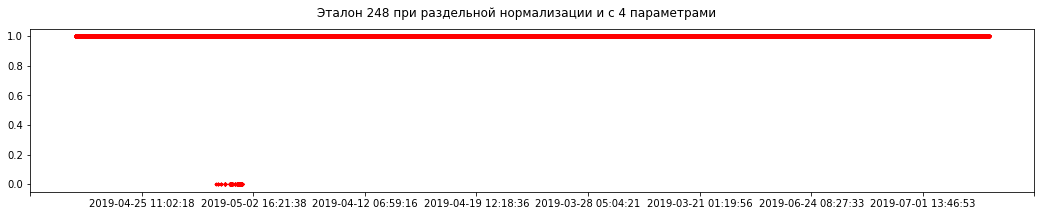

In [31]:
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Эталон 248 при раздельной нормализации и с 4 параметрами')
plt.scatter(X, test_labels,color='red',s=5)

plt.show()

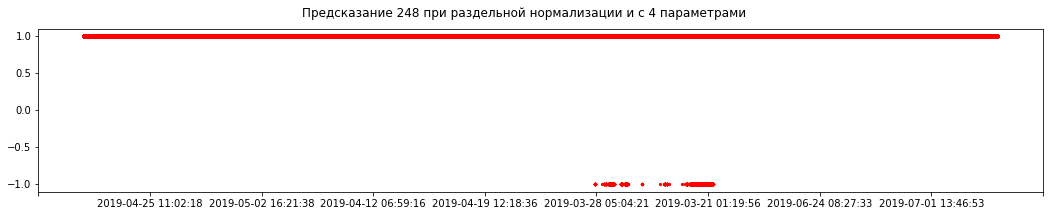

In [33]:
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Предсказание 248 при раздельной нормализации и с 4 параметрами')
plt.scatter(X, df1['anomalies'],color='red',s=5)

plt.show()

# Скорость изменения 

In [ ]:
def speed(temp):
  names = temp.columns
  speed_temp = np.array(temp)
  speed_temp = np.transpose(speed_temp)
  for j in range(0,speed_temp.shape[0]):
    temp_arr = []
    for i in range(1,len(speed_temp[j])):
      temp_arr.append(speed_temp[j][i]-speed_temp[j][i-1])
    temp_arr.append(0)
    speed_temp[j] = temp_arr
  temp = pd.DataFrame(speed_temp)
  temp = temp.transpose()
  temp.columns = names
  
  return temp

In [ ]:
speed(df1)

,HKLA_(1000 kgf),ROP5_(m/h),RPM_(c/min),STOR_(kN.m)
0,0.00727,0.0,-0.00017,-4.068000e-05
1,-0.11886,0.0,0.00101,-7.000000e-09
2,-0.22377,0.0,-0.00090,-1.762740e-04
3,0.88503,0.0,0.00118,5.288400e-04
4,-0.52173,0.0,-0.00129,-2.169600e-04
...,...,...,...,...
125929,-0.06190,0.0,-0.00118,4.881600e-04
125930,0.00212,0.0,0.00325,3.796800e-04
125931,-0.02573,0.0,-0.00201,-1.491620e-03
125932,0.01370,0.0,-0.00036,9.492200e-04


In [ ]:
from pandas.core.frame import DataFrame

temp_arr = np.array([
                      '/content/drive/MyDrive/Colab Notebooks/Annotated/220_1.csv',
                     
                     ])
df1 = pd.DataFrame()
test_labels = []
time = []
for i in range(0,len(temp_arr)):
  temp = pd.read_csv(temp_arr[i],delimiter=';')

  time = np.append(time,(temp['TIME_(s)']))

  temp = preparetion_dataset(temp)
  temp = trash(temp)

  test_labels_temp = np.array(temp.pop('labels'))
  test_labels = np.append(test_labels,test_labels_temp)

  df1 = pd.concat([df1,speed(temp)],ignore_index=True)

In [ ]:
test = df1

In [ ]:
outliers_fraction = float(.01)

In [ ]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.01)

In [ ]:
test['anomalies'] = model.predict(test)

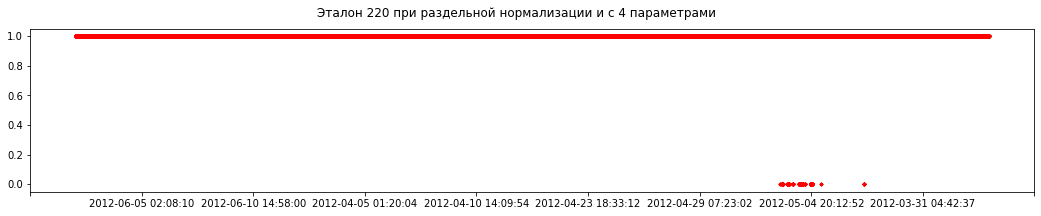

In [ ]:
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Эталон 220 при раздельной нормализации и с 4 параметрами')
plt.scatter(X, test_labels,color='red',s=5)

plt.show()

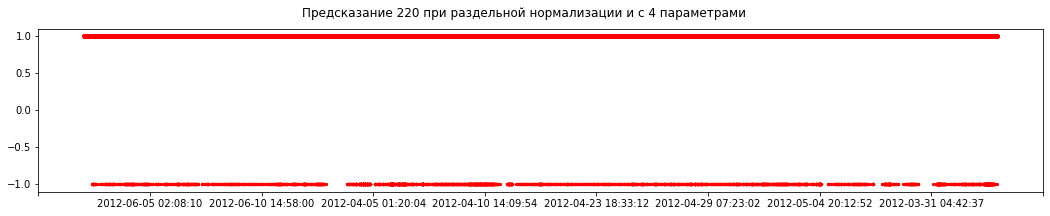

In [ ]:
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Предсказание 220 при раздельной нормализации и с 4 параметрами')
plt.scatter(X, df1['anomalies'],color='red',s=5)

plt.show()